#Clustering

## Instación de paqueterias

In [ ]:
import pandas as pd

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 7.5 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.rdMolDescriptors import CalcTPSA





In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff

In [ ]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, to_tree
import networkx as nx


## Carga base de datos

In [ ]:
#https://docs.google.com/spreadsheets/d/1OZolUkY3fxXZ64SjF1HSiyS7gjfRAp93wJtAIhrMpYo/edit?usp=sharing
df = pd.read_csv('https://docs.google.com/spreadsheets/d/1OZolUkY3fxXZ64SjF1HSiyS7gjfRAp93wJtAIhrMpYo/export?format=csv')
df

,atc_classifications,first_approval,indication_class,max_phase,molecule_chembl_id,molecule_type,pref_name,canonical_smiles
0,[],1939.0,NaN,4.0,CHEMBL1200728,Small molecule,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N
1,[],1939.0,NaN,4.0,CHEMBL1200728,Small molecule,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N
2,[],1939.0,Stimulant (gastric secretory),4.0,CHEMBL90,Small molecule,HISTAMINE,NCCc1c[nH]cn1
3,['V04CG03'],1939.0,NaN,4.0,CHEMBL3989520,Small molecule,HISTAMINE PHOSPHATE,NCCc1c[nH]cn1.O=P(O)(O)O.O=P(O)(O)O
4,['J01EB04'],1939.0,Suppressant (dermatitis herpetiformis),4.0,CHEMBL700,Small molecule,SULFAPYRIDINE,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1
...,...,...,...,...,...,...,...,...
3670,[],NaN,NaN,4.0,CHEMBL5072826,Small molecule,CALCIUM,[Ca+2].[H-].[H-]
3671,"['D11AC01', 'D08AJ04']",NaN,NaN,4.0,CHEMBL5219790,Small molecule,CETRIMIDE,NaN
3672,[],NaN,NaN,4.0,CHEMBL5219994,Small molecule,ACRIFLAVINE,NaN
3673,['J01FG01'],NaN,NaN,4.0,CHEMBL5314344,Small molecule,MIKAMYCIN,NaN


Remover moleculas que no contengan código ATC o Canonial SMILES

In [ ]:
df = df[df['atc_classifications'] != '[]']
df = df[df['canonical_smiles'].notna() & (df['canonical_smiles'] != '')]

df

,atc_classifications,first_approval,indication_class,max_phase,molecule_chembl_id,molecule_type,pref_name,canonical_smiles
3,['V04CG03'],1939.0,NaN,4.0,CHEMBL3989520,Small molecule,HISTAMINE PHOSPHATE,NCCc1c[nH]cn1.O=P(O)(O)O.O=P(O)(O)O
4,['J01EB04'],1939.0,Suppressant (dermatitis herpetiformis),4.0,CHEMBL700,Small molecule,SULFAPYRIDINE,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1
5,['H02AA03'],1939.0,Adrenocortical Steroid (salt-regulating),4.0,CHEMBL1200542,Small molecule,DESOXYCORTICOSTERONE ACETATE,CC(=O)OCC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)C...
9,"['R03DA04', 'R03DA74', 'R03DA54']",1940.0,"Bronchodilator,Diuretic; Relaxant (smooth musc...",4.0,CHEMBL190,Small molecule,THEOPHYLLINE,Cn1c(=O)c2[nH]cnc2n(C)c1=O
10,"['R03DA55', 'R03DA05']",1940.0,Relaxant (smooth muscle),4.0,CHEMBL1370561,Small molecule,AMINOPHYLLINE,Cn1c(=O)c2[nH]cnc2n(C)c1=O.Cn1c(=O)c2[nH]cnc2n...
...,...,...,...,...,...,...,...,...
3646,"['B05CB03', 'A12CC04', 'A06AD19']",NaN,NaN,4.0,CHEMBL3989480,Small molecule,MAGNESIUM CITRATE,O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].O=C([O-])C...
3652,['A12CC03'],NaN,NaN,4.0,CHEMBL3989640,Small molecule,MAGNESIUM GLUCONATE,O.O.O=C([O-])[C@H](O)[C@@H](O)[C@H](O)[C@H](O)...
3657,"['N02BB02', 'N02BB72', 'N02BB52']",NaN,NaN,4.0,CHEMBL3989803,Small molecule,DIPYRONE,Cc1c(N(C)CS(=O)(=O)[O-])c(=O)n(-c2ccccc2)n1C.O...
3663,['R03BB02'],NaN,NaN,4.0,CHEMBL4297109,Small molecule,OXITROPIUM BROMIDE,CC[N+]1(C)[C@@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[...


Expandir los códigos ATC

In [ ]:
farmaco_df2 = df

# Función para expandir las filas con múltiples códigos ATC
def expand_atc(df):
    new_rows = []
    for _, row in df.iterrows():
        atc_list = eval(row['atc_classifications'])
        for atc in atc_list:
            new_row = row.copy()
            new_row['atc_classifications'] = atc
            new_rows.append(new_row)
    new_df = pd.DataFrame(new_rows)
    return new_df

# Expandir las filas con múltiples códigos ATC
expanded_df = expand_atc(farmaco_df2)

farmaco_df2 = expanded_df
farmaco_df2

,atc_classifications,first_approval,indication_class,max_phase,molecule_chembl_id,molecule_type,pref_name,canonical_smiles
3,V04CG03,1939.0,NaN,4.0,CHEMBL3989520,Small molecule,HISTAMINE PHOSPHATE,NCCc1c[nH]cn1.O=P(O)(O)O.O=P(O)(O)O
4,J01EB04,1939.0,Suppressant (dermatitis herpetiformis),4.0,CHEMBL700,Small molecule,SULFAPYRIDINE,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1
5,H02AA03,1939.0,Adrenocortical Steroid (salt-regulating),4.0,CHEMBL1200542,Small molecule,DESOXYCORTICOSTERONE ACETATE,CC(=O)OCC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)C...
9,R03DA04,1940.0,"Bronchodilator,Diuretic; Relaxant (smooth musc...",4.0,CHEMBL190,Small molecule,THEOPHYLLINE,Cn1c(=O)c2[nH]cnc2n(C)c1=O
9,R03DA74,1940.0,"Bronchodilator,Diuretic; Relaxant (smooth musc...",4.0,CHEMBL190,Small molecule,THEOPHYLLINE,Cn1c(=O)c2[nH]cnc2n(C)c1=O
...,...,...,...,...,...,...,...,...
3657,N02BB02,NaN,NaN,4.0,CHEMBL3989803,Small molecule,DIPYRONE,Cc1c(N(C)CS(=O)(=O)[O-])c(=O)n(-c2ccccc2)n1C.O...
3657,N02BB72,NaN,NaN,4.0,CHEMBL3989803,Small molecule,DIPYRONE,Cc1c(N(C)CS(=O)(=O)[O-])c(=O)n(-c2ccccc2)n1C.O...
3657,N02BB52,NaN,NaN,4.0,CHEMBL3989803,Small molecule,DIPYRONE,Cc1c(N(C)CS(=O)(=O)[O-])c(=O)n(-c2ccccc2)n1C.O...
3663,R03BB02,NaN,NaN,4.0,CHEMBL4297109,Small molecule,OXITROPIUM BROMIDE,CC[N+]1(C)[C@@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[...


Clasificar los codigos ATC

In [ ]:
# Función para obtener la primera letra (ATP Type)
def get_atp_type(atc):
    return atc[0] if pd.notna(atc) and len(atc) > 0 else None

# Función para obtener los primeros tres caracteres (G Terapeutic)
def get_g_therapeutic(atc):
    return atc[:3] if pd.notna(atc) and len(atc) >= 3 else None

# Aplicar las funciones para crear las nuevas columnas
farmaco_df2['ATC Type'] = farmaco_df2['atc_classifications'].apply(get_atp_type)
farmaco_df2['G Terapeutic'] = farmaco_df2['atc_classifications'].apply(get_g_therapeutic)

farmaco_df2


,atc_classifications,first_approval,indication_class,max_phase,molecule_chembl_id,molecule_type,pref_name,canonical_smiles,ATC Type,G Terapeutic
3,V04CG03,1939.0,NaN,4.0,CHEMBL3989520,Small molecule,HISTAMINE PHOSPHATE,NCCc1c[nH]cn1.O=P(O)(O)O.O=P(O)(O)O,V,V04
4,J01EB04,1939.0,Suppressant (dermatitis herpetiformis),4.0,CHEMBL700,Small molecule,SULFAPYRIDINE,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,J,J01
5,H02AA03,1939.0,Adrenocortical Steroid (salt-regulating),4.0,CHEMBL1200542,Small molecule,DESOXYCORTICOSTERONE ACETATE,CC(=O)OCC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)C...,H,H02
9,R03DA04,1940.0,"Bronchodilator,Diuretic; Relaxant (smooth musc...",4.0,CHEMBL190,Small molecule,THEOPHYLLINE,Cn1c(=O)c2[nH]cnc2n(C)c1=O,R,R03
9,R03DA74,1940.0,"Bronchodilator,Diuretic; Relaxant (smooth musc...",4.0,CHEMBL190,Small molecule,THEOPHYLLINE,Cn1c(=O)c2[nH]cnc2n(C)c1=O,R,R03
...,...,...,...,...,...,...,...,...,...,...
3657,N02BB02,NaN,NaN,4.0,CHEMBL3989803,Small molecule,DIPYRONE,Cc1c(N(C)CS(=O)(=O)[O-])c(=O)n(-c2ccccc2)n1C.O...,N,N02
3657,N02BB72,NaN,NaN,4.0,CHEMBL3989803,Small molecule,DIPYRONE,Cc1c(N(C)CS(=O)(=O)[O-])c(=O)n(-c2ccccc2)n1C.O...,N,N02
3657,N02BB52,NaN,NaN,4.0,CHEMBL3989803,Small molecule,DIPYRONE,Cc1c(N(C)CS(=O)(=O)[O-])c(=O)n(-c2ccccc2)n1C.O...,N,N02
3663,R03BB02,NaN,NaN,4.0,CHEMBL4297109,Small molecule,OXITROPIUM BROMIDE,CC[N+]1(C)[C@@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[...,R,R03


Ordenar por grupo terapéutico

In [ ]:
df_sorted = farmaco_df2.sort_values(by='G Terapeutic')
df_sorted

,atc_classifications,first_approval,indication_class,max_phase,molecule_chembl_id,molecule_type,pref_name,canonical_smiles,ATC Type,G Terapeutic
189,A01AC54,1955.0,Glucocorticoid,4.0,CHEMBL131,Small molecule,PREDNISOLONE,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,A,A01
543,A01AB23,1971.0,Antibacterial,4.0,CHEMBL1434,Small molecule,MINOCYCLINE,CN(C)c1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C(O...,A,A01
2605,A01AB02,2017.0,"Anti-Infective, Topical",4.0,CHEMBL71595,Small molecule,HYDROGEN PEROXIDE,OO,A,A01
568,A01AA51,1972.0,"Dental Caries Prophylactic,Radioactive Agent",4.0,CHEMBL1528,Small molecule,SODIUM FLUORIDE,[F-].[Na+],A,A01
252,A01AC02,1958.0,Glucocorticoid,4.0,CHEMBL384467,Small molecule,DEXAMETHASONE,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,A,A01
...,...,...,...,...,...,...,...,...,...,...
1539,V10BX01,1993.0,Antineoplastic; Radioactive Agent,4.0,CHEMBL1200625,Small molecule,STRONTIUM CHLORIDE SR 89,[89Sr+2].[Cl-].[Cl-],V,V10
3314,V10XA01,NaN,Diagnostic Aid (thyroid function determination...,4.0,CHEMBL1201084,Small molecule,SODIUM IODIDE I 131,[131I-].[Na+],V,V10
225,V10XX01,1957.0,Diagnostic Aid (neoplasm); Antineoplastic; Rad...,4.0,CHEMBL2107525,Small molecule,SODIUM PHOSPHATE P 32,O=[32P]([O-])([O-])O.[Na+].[Na+],V,V10
2400,V10XX03,2013.0,NaN,4.0,CHEMBL2107816,Small molecule,RADIUM RA 223 DICHLORIDE,Cl[223Ra]Cl,V,V10


## Cálculo de identificadores químicos

calcular identificadores químicos

In [ ]:
df_sorted

# Función para calcular las propiedades
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mol_weight = Descriptors.MolWt(mol)
        logp = MolLogP(mol)
        tpsa = CalcTPSA(mol)
        nrb = Descriptors.NumRotatableBonds(mol)
        hba = Descriptors.NumHAcceptors(mol)
        hbd = Descriptors.NumHDonors(mol)
        return pd.Series([mol_weight, logp, tpsa, nrb, hba, hbd])
    else:
        return pd.Series([None, None, None, None, None, None])

# Aplicar la función a cada fila del DataFrame
df_sorted[['MolWt', 'LogP', 'TPSA', 'nRB', 'HBA', 'HBD']] = df_sorted['canonical_smiles'].apply(calculate_properties)

# Mostrar el DataFrame resultante
df_sorted


[22:25:57] WARNING: not removing hydrogen atom without neighbors
[22:25:57] WARNING: not removing hydrogen atom without neighbors
[22:25:57] WARNING: not removing hydrogen atom without neighbors
[22:25:57] WARNING: not removing hydrogen atom without neighbors


,atc_classifications,first_approval,indication_class,max_phase,molecule_chembl_id,molecule_type,pref_name,canonical_smiles,ATC Type,G Terapeutic,MolWt,LogP,TPSA,nRB,HBA,HBD
189,A01AC54,1955.0,Glucocorticoid,4.0,CHEMBL131,Small molecule,PREDNISOLONE,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,A,A01,360.450000,1.55760,94.83,2.0,5.0,3.0
543,A01AB23,1971.0,Antibacterial,4.0,CHEMBL1434,Small molecule,MINOCYCLINE,CN(C)c1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C(O...,A,A01,457.483000,0.18660,164.63,3.0,9.0,5.0
2605,A01AB02,2017.0,"Anti-Infective, Topical",4.0,CHEMBL71595,Small molecule,HYDROGEN PEROXIDE,OO,A,A01,34.014000,0.01740,40.46,0.0,2.0,2.0
568,A01AA51,1972.0,"Dental Caries Prophylactic,Radioactive Agent",4.0,CHEMBL1528,Small molecule,SODIUM FLUORIDE,[F-].[Na+],A,A01,41.988000,-5.99200,0.00,0.0,0.0,0.0
252,A01AC02,1958.0,Glucocorticoid,4.0,CHEMBL384467,Small molecule,DEXAMETHASONE,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,A,A01,392.467000,1.89570,94.83,2.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,V10BX01,1993.0,Antineoplastic; Radioactive Agent,4.0,CHEMBL1200625,Small molecule,STRONTIUM CHLORIDE SR 89,[89Sr+2].[Cl-].[Cl-],V,V10,159.813451,-6.37280,0.00,0.0,0.0,0.0
3314,V10XA01,NaN,Diagnostic Aid (thyroid function determination...,4.0,CHEMBL1201084,Small molecule,SODIUM IODIDE I 131,[131I-].[Na+],V,V10,153.896125,-5.99200,0.00,0.0,0.0,0.0
225,V10XX01,1957.0,Diagnostic Aid (neoplasm); Antineoplastic; Rad...,4.0,CHEMBL2107525,Small molecule,SODIUM PHOSPHATE P 32,O=[32P]([O-])([O-])O.[Na+].[Na+],V,V10,142.957907,-8.18460,83.42,0.0,3.0,1.0
2400,V10XX03,2013.0,NaN,4.0,CHEMBL2107816,Small molecule,RADIUM RA 223 DICHLORIDE,Cl[223Ra]Cl,V,V10,293.924502,1.37900,0.00,0.0,0.0,0.0


Realizar promedio para cada identificador agrupando por grupo ATC

In [ ]:
# Calcular el promedio por cada tipo de "ATP Type"
averages = df_sorted.groupby('ATC Type')[['MolWt', 'LogP', 'TPSA', 'nRB', 'HBA', 'HBD']].mean().reset_index()


# Mostrar el promedio de cada propiedad por grupo
print("Promedio de propiedades por ATC Type:")
print(averages)


Promedio de propiedades por ATC Type:
   ATC Type       MolWt      LogP        TPSA       nRB       HBA       HBD
0         A  344.129076  0.567591  102.287020  4.711921  5.145695  2.394040
1         B  302.030341  0.156899   95.928171  4.939024  4.634146  2.268293
2         C  362.585057  2.357222   88.733030  5.840909  5.272727  1.996212
3         D  343.178155  2.719511   75.449513  4.070796  4.407080  1.871681
4         G  363.595434  3.465389   66.120559  4.020979  4.062937  1.629371
5         H  412.779919  2.380588   89.183243  4.729730  5.162162  2.054054
6         J  462.284081  0.910497  144.588259  6.044534  8.283401  3.433198
7         L  444.378311  2.857648  106.906316  5.728070  6.706140  2.359649
8         M  321.516061  2.678056   69.927634  4.587786  3.709924  1.343511
9         N  289.122047  2.557626   48.023928  3.679518  3.248193  0.966265
10        P  296.443386  3.054134   59.477143  3.857143  3.871429  1.157143
11        R  324.938101  2.679666   57.116651  4.8

In [ ]:
from google.colab import files
df_sorted.to_csv("FarmacoV1.csv", index=False)
files.download("FarmacoV1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Clasificación de ATC

## Normalización de Datos

In [ ]:
averages

,ATC Type,MolWt,LogP,TPSA,nRB,HBA,HBD
0,A,344.129076,0.567591,102.287020,4.711921,5.145695,2.394040
1,B,302.030341,0.156899,95.928171,4.939024,4.634146,2.268293
2,C,362.585057,2.357222,88.733030,5.840909,5.272727,1.996212
3,D,343.178155,2.719511,75.449513,4.070796,4.407080,1.871681
4,G,363.595434,3.465389,66.120559,4.020979,4.062937,1.629371
5,H,412.779919,2.380588,89.183243,4.729730,5.162162,2.054054
6,J,462.284081,0.910497,144.588259,6.044534,8.283401,3.433198
7,L,444.378311,2.857648,106.906316,5.728070,6.706140,2.359649
8,M,321.516061,2.678056,69.927634,4.587786,3.709924,1.343511
9,N,289.122047,2.557626,48.023928,3.679518,3.248193,0.966265


In [ ]:
le_atp = LabelEncoder()
averages['ATC Type Encoded'] = le_atp.fit_transform(averages['ATC Type'])

data = averages[['ATC Type Encoded', 'MolWt', 'LogP', 'TPSA', 'nRB', 'HBA', 'HBD']].values
data

array([[0.00000000e+00, 3.44129076e+02, 5.67590927e-01, 1.02287020e+02,
        4.71192053e+00, 5.14569536e+00, 2.39403974e+00],
       [1.00000000e+00, 3.02030341e+02, 1.56898659e-01, 9.59281707e+01,
        4.93902439e+00, 4.63414634e+00, 2.26829268e+00],
       [2.00000000e+00, 3.62585057e+02, 2.35722205e+00, 8.87330303e+01,
        5.84090909e+00, 5.27272727e+00, 1.99621212e+00],
       [3.00000000e+00, 3.43178155e+02, 2.71951133e+00, 7.54495133e+01,
        4.07079646e+00, 4.40707965e+00, 1.87168142e+00],
       [4.00000000e+00, 3.63595434e+02, 3.46538923e+00, 6.61205594e+01,
        4.02097902e+00, 4.06293706e+00, 1.62937063e+00],
       [5.00000000e+00, 4.12779919e+02, 2.38058811e+00, 8.91832432e+01,
        4.72972973e+00, 5.16216216e+00, 2.05405405e+00],
       [6.00000000e+00, 4.62284081e+02, 9.10497166e-01, 1.44588259e+02,
        6.04453441e+00, 8.28340081e+00, 3.43319838e+00],
       [7.00000000e+00, 4.44378311e+02, 2.85764772e+00, 1.06906316e+02,
        5.72807018e+00, 6

In [ ]:
# normalización por z
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
data = scaled_data

le_atp = LabelEncoder()
averages['ATC Type Encoded'] = le_atp.fit_transform(averages['ATC Type'])
averages.set_index('ATC Type', inplace=True)
scaled_datas = scaler.fit_transform(averages)
scaled_df = pd.DataFrame(scaled_datas, index=averages.index, columns=averages.columns)
scaled_df

,MolWt,LogP,TPSA,nRB,HBA,HBD,ATC Type Encoded
ATC Type,,,,,,,
A,-0.259469,-1.313767,0.702563,-0.016678,0.207354,0.588929,-1.612452
B,-1.088736,-1.692778,0.440441,0.306377,-0.184420,0.394540,-1.364382
C,0.104080,0.337811,0.143844,1.589303,0.304643,-0.026063,-1.116313
D,-0.278200,0.672153,-0.403725,-0.928673,-0.358320,-0.218572,-0.868243
G,0.123983,1.360493,-0.788281,-0.999539,-0.621885,-0.593155,-0.620174
H,1.092826,0.359375,0.162403,0.008656,0.219966,0.063353,-0.372104
J,2.067966,-0.997312,2.446294,1.878960,2.610391,2.195340,-0.124035
L,1.715256,0.799633,0.892979,1.428791,1.402433,0.535765,0.124035
M,-0.704903,0.633895,-0.631347,-0.193258,-0.892243,-1.035058,0.372104


Normalización Mín-Max
de 0 a 1

In [ ]:
# Ejemplo usando MinMaxScaler para normalización
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Ahora scaled_data contiene tus datos normalizados
data  = scaled_data

In [ ]:
data

array([[0.00000000e+00, 3.44129076e+02, 5.67590927e-01, 1.02287020e+02,
        4.71192053e+00, 5.14569536e+00, 2.39403974e+00],
       [1.00000000e+00, 3.02030341e+02, 1.56898659e-01, 9.59281707e+01,
        4.93902439e+00, 4.63414634e+00, 2.26829268e+00],
       [2.00000000e+00, 3.62585057e+02, 2.35722205e+00, 8.87330303e+01,
        5.84090909e+00, 5.27272727e+00, 1.99621212e+00],
       [3.00000000e+00, 3.43178155e+02, 2.71951133e+00, 7.54495133e+01,
        4.07079646e+00, 4.40707965e+00, 1.87168142e+00],
       [4.00000000e+00, 3.63595434e+02, 3.46538923e+00, 6.61205594e+01,
        4.02097902e+00, 4.06293706e+00, 1.62937063e+00],
       [5.00000000e+00, 4.12779919e+02, 2.38058811e+00, 8.91832432e+01,
        4.72972973e+00, 5.16216216e+00, 2.05405405e+00],
       [6.00000000e+00, 4.62284081e+02, 9.10497166e-01, 1.44588259e+02,
        6.04453441e+00, 8.28340081e+00, 3.43319838e+00],
       [7.00000000e+00, 4.44378311e+02, 2.85764772e+00, 1.06906316e+02,
        5.72807018e+00, 6

In [ ]:
le_atp = LabelEncoder()
averages['ATC Type Encoded'] = le_atp.fit_transform(averages['ATC Type'])
averages.set_index('ATC Type', inplace=True)
scaled_datas = scaler.fit_transform(averages)
scaled_df = pd.DataFrame(scaled_datas, index=averages.index, columns=averages.columns)
scaled_df

KeyError: 'ATC Type'

## Clustering Jerarquico

In [ ]:
scaledJ_df = scaled_df
scaledJ_df.drop('ATC Type Encoded', axis=1, inplace=True)

In [ ]:
# Calcular la matriz de distancias y realizar el clustering jerárquico
Z = linkage(scaledJ_df, method='ward')

# Crear el dendrograma
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=averages.index, leaf_rotation=90., leaf_font_size=30)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [ ]:
import plotly.figure_factory as ff

# Crear el dendrograma usando Plotly
fig = ff.create_dendrogram(scaledJ_df, labels=averages.index, linkagefun=lambda x: linkage(x, 'ward'))
fig.update_layout(width=1000, height=800)
fig.show()


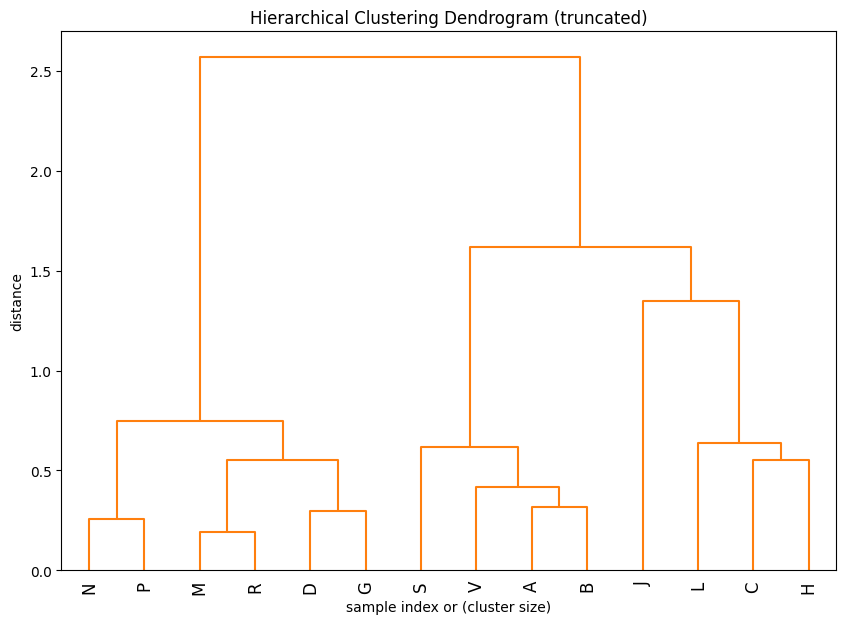

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Función para hacer el dendrograma circular
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate('%.3g' % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

plt.figure(figsize=(10, 7))
fancy_dendrogram(Z, labels=averages.index, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=10, max_d=50)
plt.show()


## Colormap

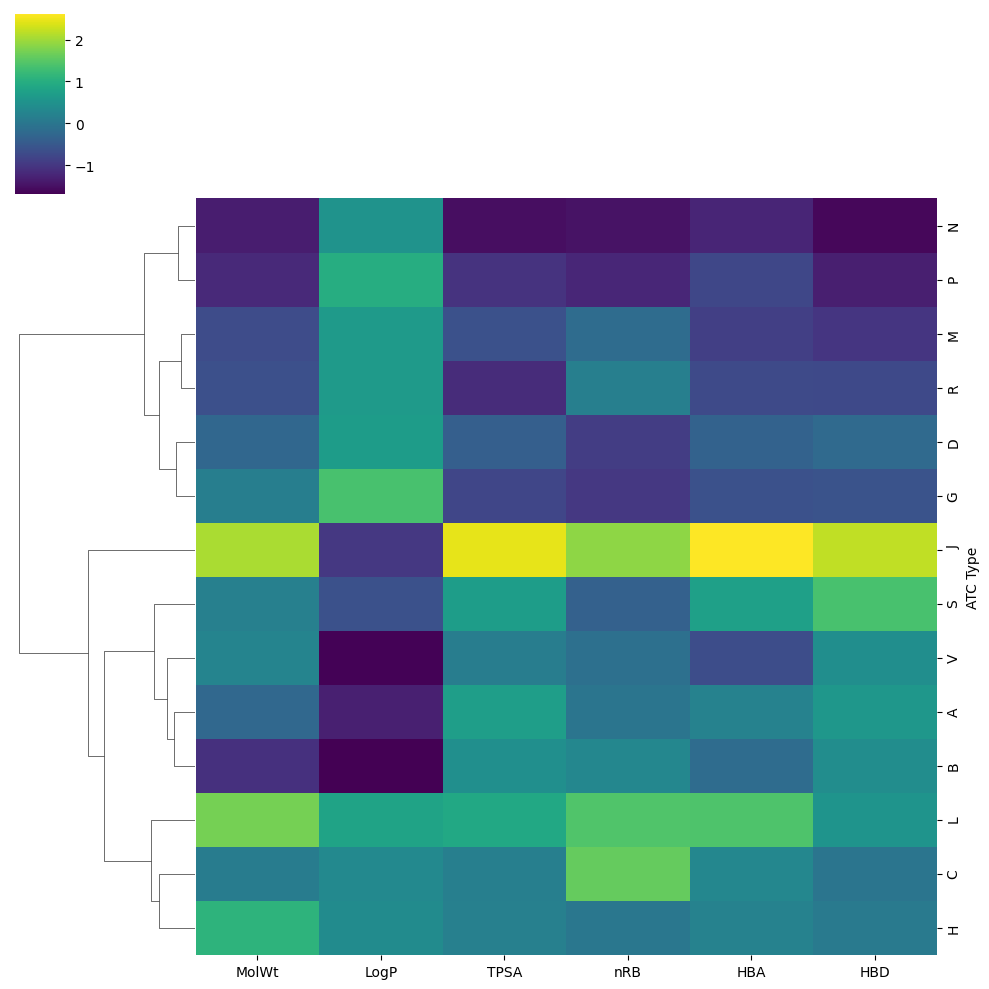

In [ ]:

# Calcular la matriz de distancias
row_clusters = linkage(scaledJ_df, method='ward')

# Crear el heatmap con el dendrograma
sns.clustermap(scaledJ_df, row_cluster=True, col_cluster=False, row_linkage=row_clusters, cmap="viridis", figsize=(10, 10))
plt.show()


## Gráfico de radar

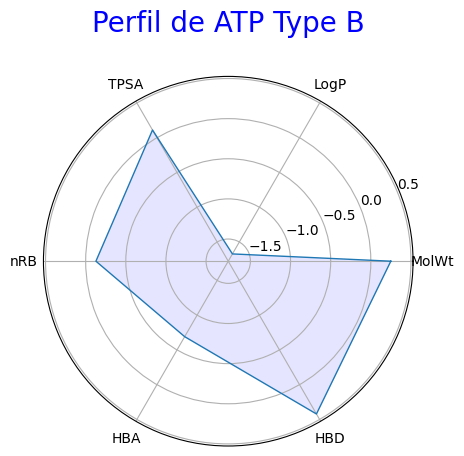

In [ ]:
# Función para crear un gráfico de radar
def plot_radar(scaledJ_df, row, title):
    categories = list(scaledJ_df.columns)
    values = scaledJ_df.loc[row].values.flatten().tolist()

    N = len(categories)

    # Repetir el primer valor al final para cerrar el círculo
    values += values[:1]

    # Calcula los ángulos para cada categoría
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Inicializa el gráfico de radar
    ax = plt.subplot(111, polar=True)

    # Dibuja una línea alrededor del círculo
    plt.xticks(angles[:-1], categories)

    # Dibuja los datos
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Rellena el área
    ax.fill(angles, values, 'b', alpha=0.1)

    # Añade el título
    plt.title(title, size=20, color='blue', y=1.1)

    plt.show()

# Ejemplo de uso
plot_radar(scaledJ_df, 'V', 'Perfil de ATP Type B')

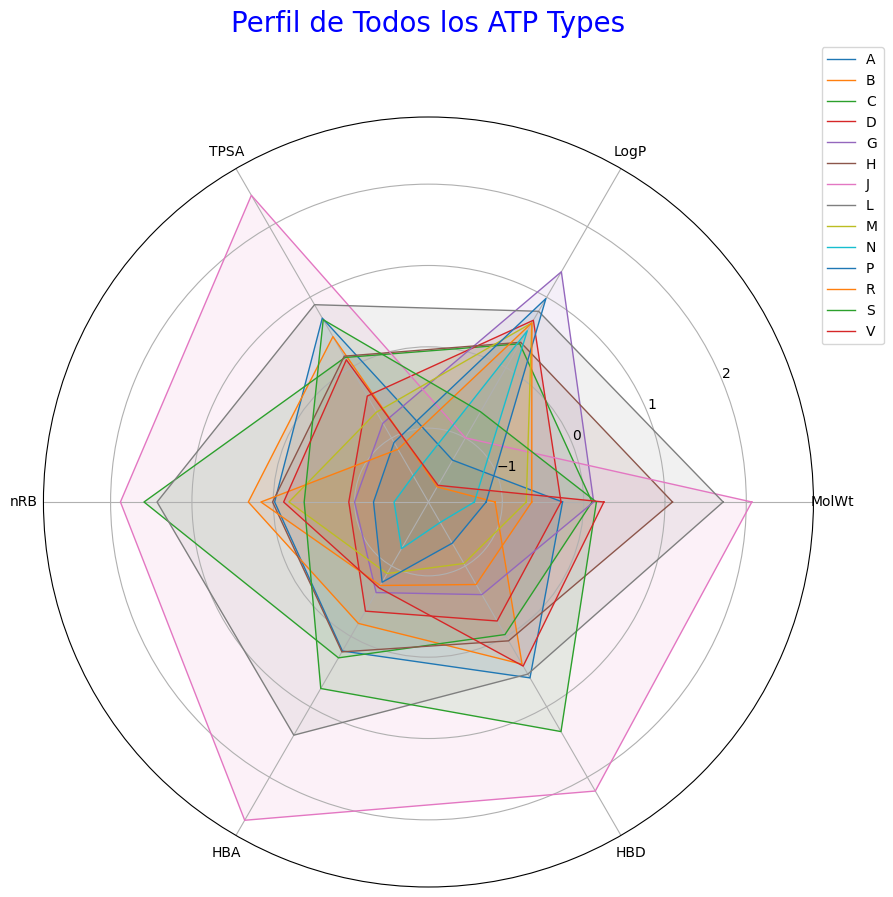

In [ ]:
def plot_radar_all(scaledJ_df, title):
    categories = list(scaledJ_df.columns)
    N = len(categories)

    # Calcula los ángulos para cada categoría
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Inicializa el gráfico de radar
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Dibuja una línea alrededor del círculo
    plt.xticks(angles[:-1], categories)

    # Dibuja los datos para cada fila del DataFrame
    for index, row in scaledJ_df.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=index)
        ax.fill(angles, values, alpha=0.1)

    # Añade el título y la leyenda
    plt.title(title, size=20, color='blue', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.show()

# Ejemplo de uso
plot_radar_all(scaledJ_df, 'Perfil de Todos los ATP Types')

## Diagrama de arbol


prog='neato'
prog='dot'
prog='twopi'
‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’

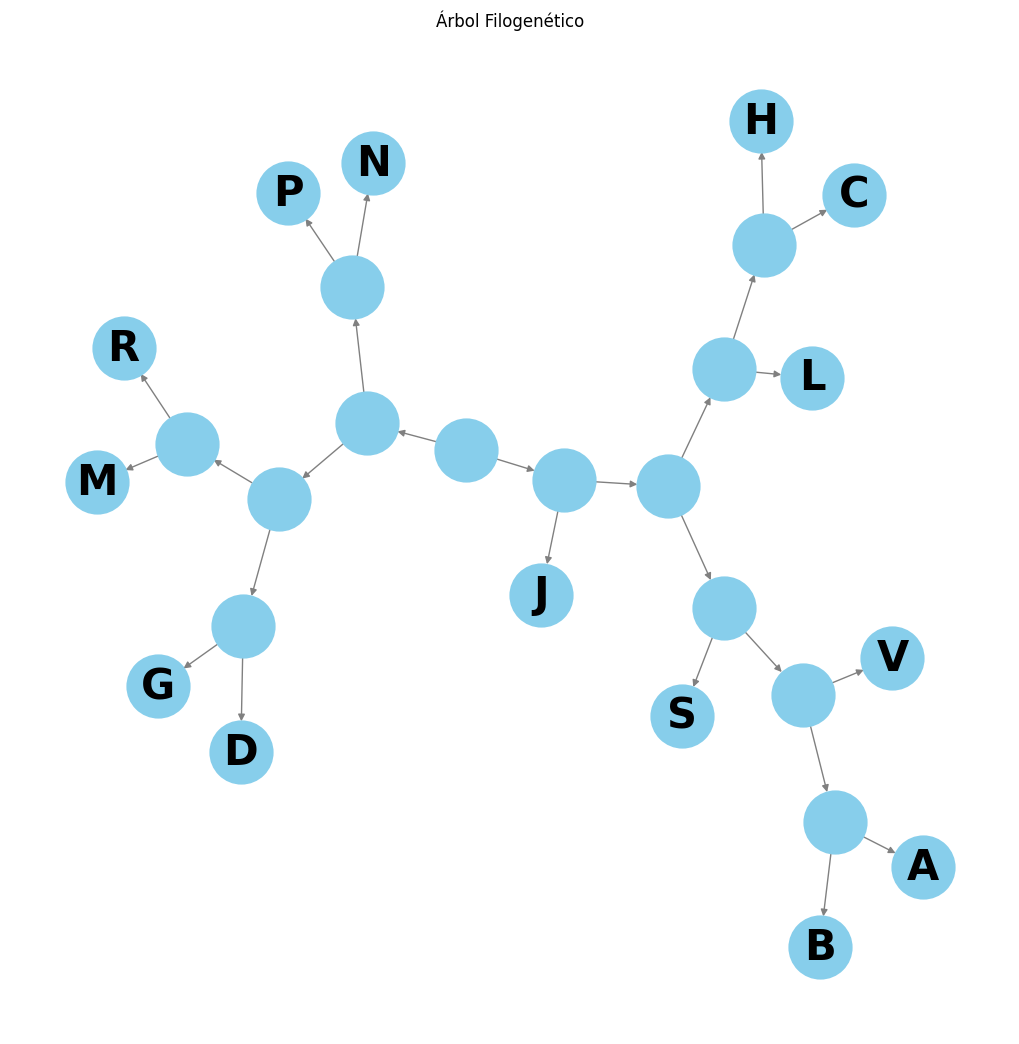

In [ ]:


# Calcular la matriz de distancias
Z = linkage(scaled_df, method='ward')

# Convertir la jerarquía a un formato de árbol
def build_tree(Z, labels):
    tree = nx.DiGraph()
    n = len(Z) + 1
    for i, (left, right, dist, _) in enumerate(Z):
        left, right = int(left), int(right)
        tree.add_node(n + i, label=str(n + i), distance=dist)
        tree.add_edge(n + i, left, weight=dist)
        tree.add_edge(n + i, right, weight=dist)
    for i, label in enumerate(labels):
        tree.add_node(i, label=label, distance=0)
    return tree

tree = build_tree(Z, scaled_df.index)

# Dibujar el árbol filogenético
pos = nx.drawing.nx_pydot.graphviz_layout(tree, prog='neato')

# Extraer etiquetas solo para las hojas
labels = {node: tree.nodes[node]['label'] if node < len(df.index) else '' for node in tree.nodes()}


plt.figure(figsize=(10, 10))
nx.draw(tree, pos, with_labels=True, labels=labels, node_size=2000, font_size=30,  node_color='skyblue', edge_color='gray', font_weight='bold', linewidths=1.5)
plt.title('Árbol Filogenético')
plt.show()


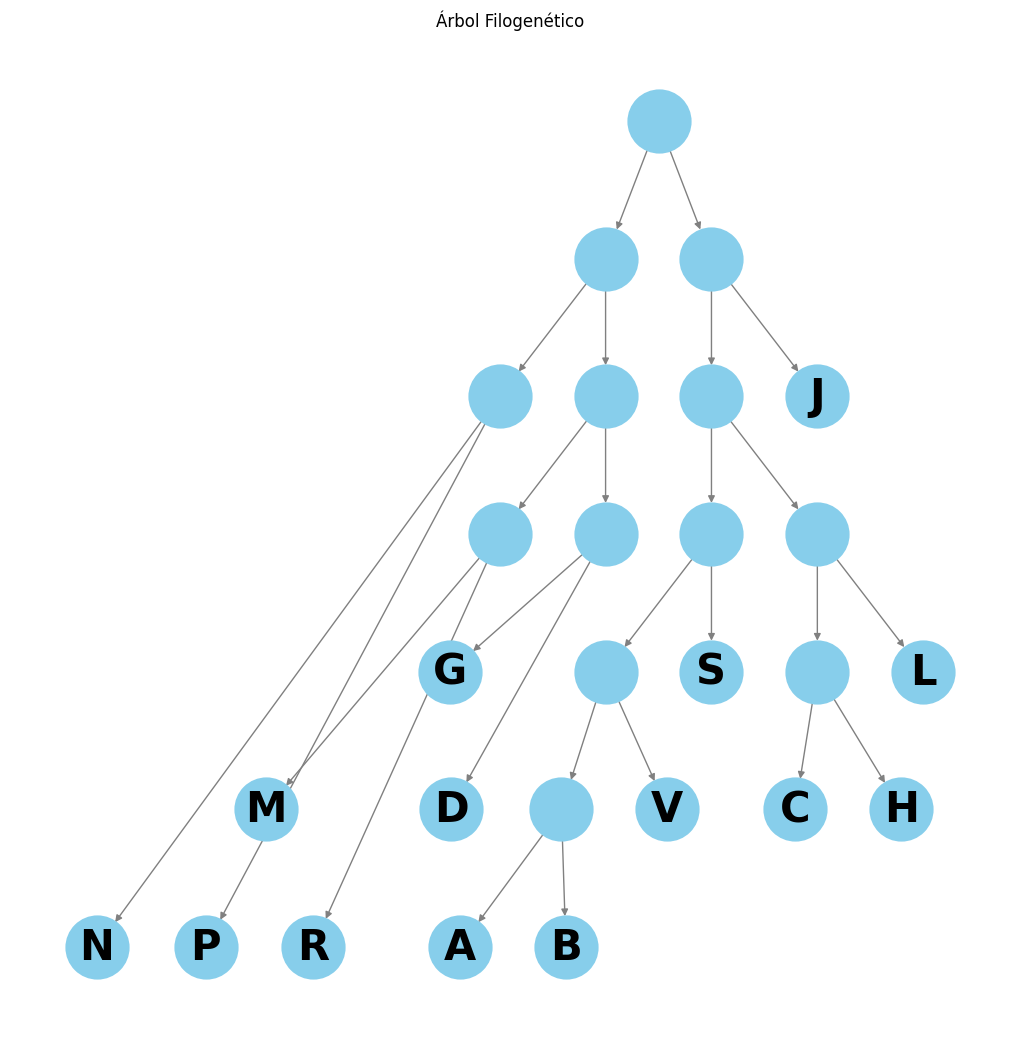

In [ ]:
pos = nx.drawing.nx_pydot.graphviz_layout(tree, prog='dot')

# Extraer etiquetas solo para las hojas
labels = {node: tree.nodes[node]['label'] if node < len(df.index) else '' for node in tree.nodes()}


plt.figure(figsize=(10, 10))
nx.draw(tree, pos, with_labels=True, labels=labels, node_size=2000, font_size=30,  node_color='skyblue', edge_color='gray', font_weight='bold', linewidths=1.5)
plt.title('Árbol Filogenético')
plt.show()

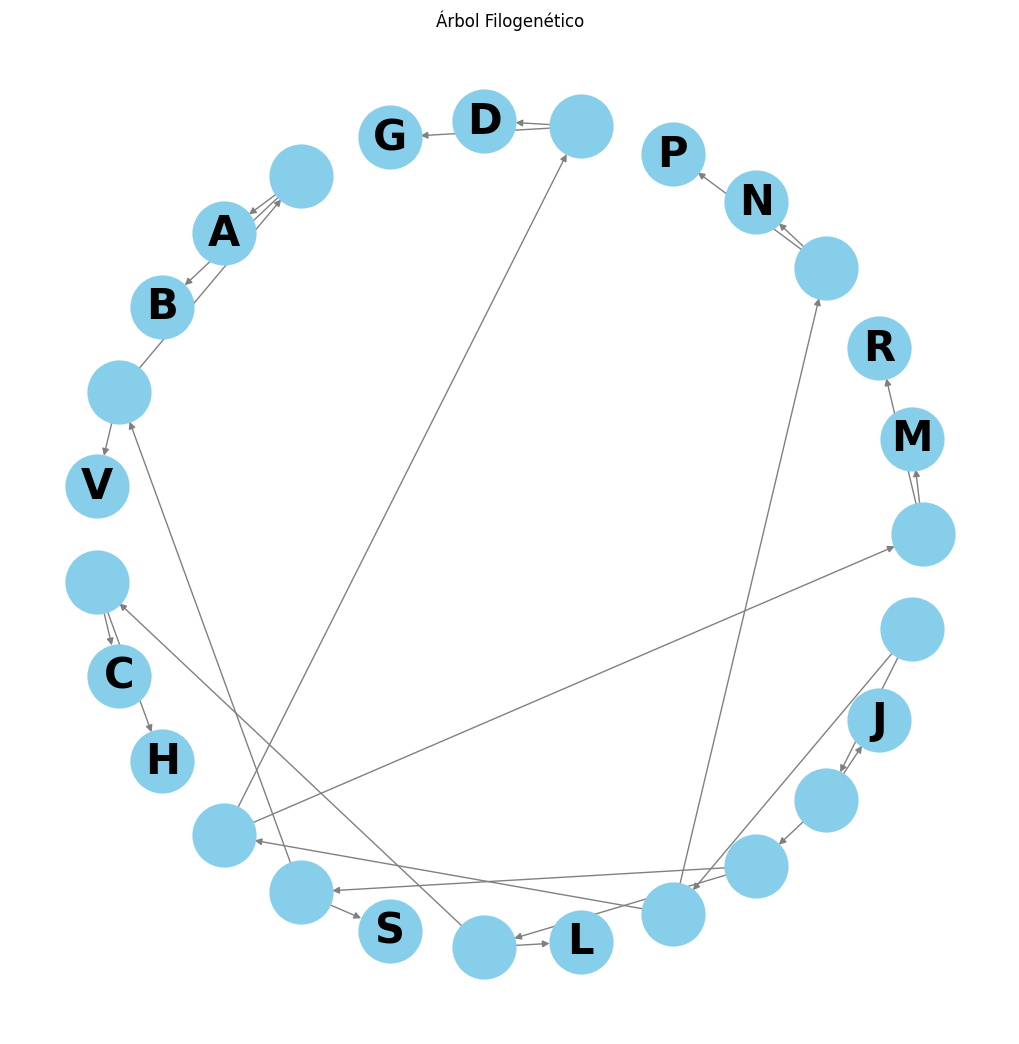

In [ ]:
pos = nx.circular_layout(tree)

# Extraer etiquetas solo para las hojas
labels = {node: tree.nodes[node]['label'] if node < len(df.index) else '' for node in tree.nodes()}


plt.figure(figsize=(10, 10))
nx.draw(tree, pos, with_labels=True, labels=labels, node_size=2000, font_size=30,  node_color='skyblue', edge_color='gray', font_weight='bold', linewidths=1.5)
plt.title('Árbol Filogenético')
plt.show()

## PCA y Kmeans


In [ ]:
scaled_df

,MolWt,LogP,TPSA,nRB,HBA,HBD
ATC Type,,,,,,
A,-0.259469,-1.313767,0.702563,-0.016678,0.207354,0.588929
B,-1.088736,-1.692778,0.440441,0.306377,-0.184420,0.394540
C,0.104080,0.337811,0.143844,1.589303,0.304643,-0.026063
D,-0.278200,0.672153,-0.403725,-0.928673,-0.358320,-0.218572
G,0.123983,1.360493,-0.788281,-0.999539,-0.621885,-0.593155
H,1.092826,0.359375,0.162403,0.008656,0.219966,0.063353
J,2.067966,-0.997312,2.446294,1.878960,2.610391,2.195340
L,1.715256,0.799633,0.892979,1.428791,1.402433,0.535765
M,-0.704903,0.633895,-0.631347,-0.193258,-0.892243,-1.035058


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_pca = scaled_df.copy()
#data_pca = data_pca.drop(labels = ['DataBase'],axis = 1)
#What StandardScaler() does is scaling the data. The fit.transform() module fits these new values to the data,
#and stores them, replacing the old values.
data_pca = StandardScaler().fit_transform(data_pca)
#Apply PCA on the transformed (scaled and centered) data:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_pca)
pca_results

array([[ 0.90227223,  1.34591215],
       [ 0.40752681,  1.97175126],
       [ 0.77890458, -0.68214397],
       [-1.09302552, -0.26964162],
       [-1.59828765, -1.0552037 ],
       [ 0.553041  , -0.78458124],
       [ 5.11975757, -0.29109519],
       [ 2.33937205, -1.77027168],
       [-1.67711092, -0.26450788],
       [-3.25811711,  0.21614594],
       [-2.64642865, -0.26942015],
       [-1.54941525, -0.39143705],
       [ 1.3268895 ,  0.70057284],
       [ 0.39462135,  1.5439203 ]])

In [ ]:
pca_df = pd.DataFrame(pca_results, index=averages.index, columns=['PC1', 'PC2'])
pca_df

,PC1,PC2
ATC Type,,
A,0.902272,1.345912
B,0.407527,1.971751
C,0.778905,-0.682144
D,-1.093026,-0.269642
G,-1.598288,-1.055204
H,0.553041,-0.784581
J,5.119758,-0.291095
L,2.339372,-1.770272
M,-1.677111,-0.264508


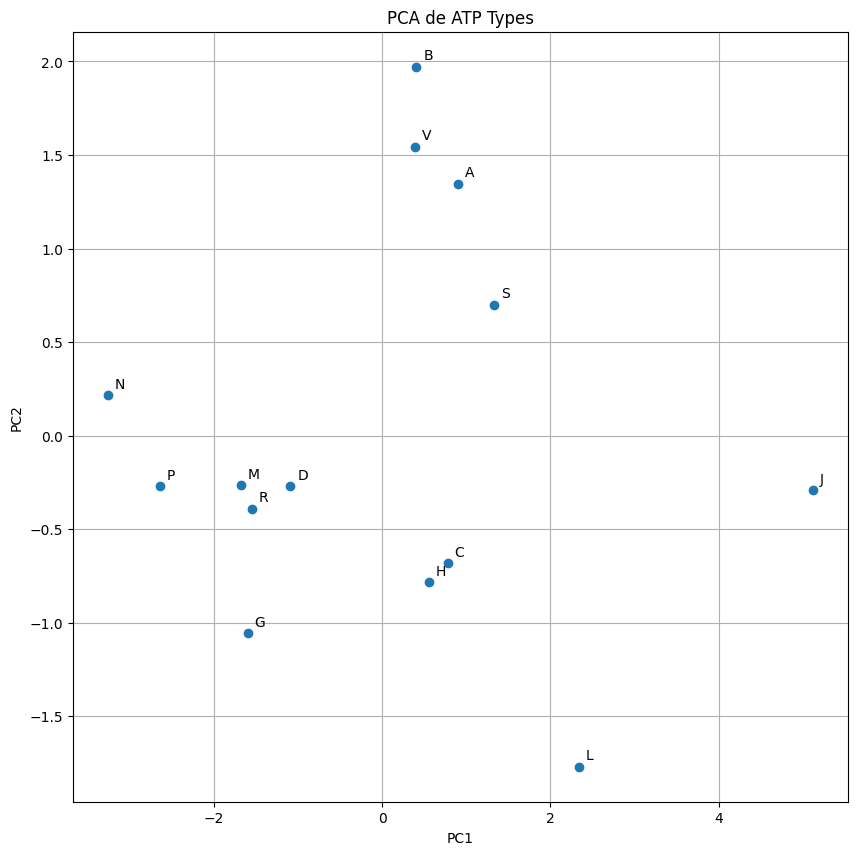

In [ ]:
# Visualizar los resultados
plt.figure(figsize=(10, 10))
plt.scatter(pca_df['PC1'], pca_df['PC2'])

# Añadir etiquetas
for label, x, y in zip(pca_df.index, pca_df['PC1'], pca_df['PC2']):
    plt.annotate(label, xy=(x, y), xytext=(5, 5), textcoords='offset points')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA de ATP Types')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns

# Aplicar K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
caled_df.index = kmeans.labels_

# Visualizar los clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='0', y='1', hue='Cluster', data=caled_df, palette='viridis')
plt.title('K-means Clustering')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



ValueError: Could not interpret value `0` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x700 with 0 Axes>

## Extra

In [ ]:
import plotly.figure_factory as ff

fig = ff.create_dendrogram(scaled_df.values, labels=scaled_df.index, orientation='left')
fig.update_layout(width=800, height=800)
fig.show()